Yelnur Shauketbek: Variational Autoencoder: digits generation

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
Trns = transforms.ToTensor()
def preprocess(img):
  img = Trns(img)
  H, W = img.shape[1:]
  img = img.reshape((H*W, ))
  return img

MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=preprocess)

In [4]:
batch_size = 128
dataloader = DataLoader(MNIST, batch_size=batch_size, shuffle=True)

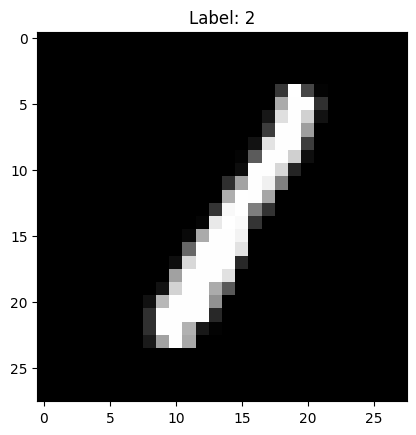

In [5]:
data_iter = iter(dataloader)
images, labels = next(data_iter)

plt.imshow(images[0].reshape(28,28), cmap='gray')
plt.title(f"Label: {labels[0]+1}")
plt.show()

In [6]:
class VAE(nn.Module):
  def __init__(self, input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun):
    super().__init__()
  
    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.latent_dim = latent_dim

    activation_functions = {'linear':transforms.Lambda(lambda x: x), 'sigmoid':F.sigmoid, 'relu':F.relu, 'tanh': F.tanh, 'leaky_relu': F.leaky_relu}
    assert act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[act_fun]
    self.last_af = activation_functions[last_layer_act_fun]

    for layer_idx in range(len(ENC_LAYERS)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, ENC_LAYERS[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(ENC_LAYERS[layer_idx-1], ENC_LAYERS[layer_idx]))
    
    ### TO COMPLETE
    # 1. define the dense layers that model z_mean and z_var
    self.linear_mean = nn.Linear(input_dim,self.latent_dim)# [your code here]
    self.linear_var = nn.Linear(input_dim,self.latent_dim)# [your code here]
    ###

    if len(DEC_LAYERS) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(ENC_LAYERS[-1], input_dim))
    else:
      for layer_idx in range(len(DEC_LAYERS)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(latent_dim, DEC_LAYERS[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(DEC_LAYERS[layer_idx-1], DEC_LAYERS[layer_idx]))

    self.final_fc = nn.Linear(DEC_LAYERS[-1], input_dim)
  
  def sampling(self, z_mean, z_var):
    ### TO COMPLETE
    # 2. write the sampling function that implements the reparametrization trick
    first_part = torch.exp(0.5*z_var)
    second_part = torch.randn_like(first_part)
    z = second_part.mul(first_part).add_(z_mean)
    return z
    ###

  def encode(self, x):
    """This function implmements the encoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.E_layers:
      x = self.af(layer(x))
    return x

  def decode(self, z):
    """This function implmements the decoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.D_layers:
      z = self.af(layer(z))
    
    out = self.final_fc(z)

    return self.last_af(out)
  
  def forward(self, x):
    x = self.encode(x)

    ### TO COMPLETE
    # 3. use the linear layers and the sampling function you defined above
    # to compute the sample z
    # [your code here]
    global z_mean, z_var
    z_mean = self.linear_mean(x)
    z_var = self.linear_var(x)
    self.z = self.sampling(z_mean, z_var) # [your code here]
    
    ###
    return self.decode(self.z)

In [7]:
#let's define the reconstruction loss...
REC_LOSS = nn.BCELoss() ### TO COMPLETE 

#..and the Kullback-Liebler Divergence
def KL_LOSS(model):
  loss = torch.mean(-z_var/2  + (torch.exp(z_var/2)**2 + z_mean**2)/2 - 1/2) ### TO COMPLETE
  return loss
  ###

In [8]:
def train(model, optimizer, dataloader, epochs, Beta=1e-3):
  loss_train_rec, loss_train_kl, loss_train = [], [], []

  for epoch in range(epochs):
    model.train()
    n_train_batches, rec_train, kl_train, total_loss_train = 0, 0, 0, 0

    for idx, (img, _) in enumerate(dataloader):
      # reset the gradient for all parameters
      optimizer.zero_grad()
      
      # move the input to currently used device
      img = img.to(device)

      # run the model
      rec_img = model(img)
      # compute the loss for this sample
      rec_loss = REC_LOSS(rec_img, img)
      kl_loss = KL_LOSS(model)
      total_loss = rec_loss + Beta * kl_loss

      # accumulate the loss for this epoch
      total_loss_train += total_loss
      rec_train += rec_loss
      kl_train += kl_loss

      # compute the gradients and update weights
      total_loss.backward()
      optimizer.step()

      n_train_batches += 1

    # compute losses for this epoch
    avg_loss_train = total_loss_train/n_train_batches
    avg_rec_loss_train = rec_train/n_train_batches
    avg_kl_loss_train = kl_train/n_train_batches

    # store losses
    loss_train.append(avg_loss_train.item())
    loss_train_rec.append(avg_rec_loss_train.item())
    loss_train_kl.append(avg_kl_loss_train.item())

    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}", end=' ----- ')
      print(f"Rec Loss: {avg_rec_loss_train:.8f}", end=' ----- ')
      print(f"Effective KL Loss: {Beta * avg_kl_loss_train:.8f}")

  return loss_train, loss_train_rec, loss_train_kl

In [9]:
def plot_losses(loss_train, loss_rec, loss_kl):
  plt.subplot(2, 1, 1)
  plt.grid(True)
  plt.title("Reconstruction Loss")
  plt.plot(loss_rec)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  print("\n")

  plt.subplot(2, 1, 2)
  plt.title("KL Loss")
  plt.grid(True)
  plt.plot(loss_kl)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

In [10]:
### TO COMPLETE
# ENC_LAYERS and DEC_LAYERS should be lists describing the number and size of 
# encoding / decoding layers
input_dim =  784 ###TO COMPLETE
ENC_LAYERS =  [256,512,784] ###TO COMPLETE
latent_dim = 2
DEC_LAYERS =  [784,512,256] ###TO COMPLETE
act_fun =  'relu' ###TO COMPLETE
last_layer_act_fun = 'sigmoid' ###TO COMPLETE
###

vae = VAE(input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun).to(device)
summary(vae, input_size=(input_dim, ))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [784]                     --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [256]                     200,960
│    └─Linear: 2-2                       [512]                     131,584
│    └─Linear: 2-3                       [784]                     402,192
├─Linear: 1-2                            [2]                       1,570
├─Linear: 1-3                            [2]                       1,570
├─ModuleList: 1-4                        --                        --
│    └─Linear: 2-4                       [784]                     2,352
│    └─Linear: 2-5                       [512]                     401,920
│    └─Linear: 2-6                       [256]                     131,328
├─Linear: 1-5                            [784]                     201,488
Total params: 1,474,964
Trainable params: 1,47

In [11]:
lr = 1e-3
epochs = 30

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [12]:
start = timer()
loss_train, loss_rec, loss_kl = train(vae, optimizer, dataloader, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.23730746 ----- Rec Loss: 0.23525390 ----- Effective KL Loss: 0.00205341
epoch: 2 -> Loss: 0.19815634 ----- Rec Loss: 0.19486071 ----- Effective KL Loss: 0.00329557
epoch: 3 -> Loss: 0.18847132 ----- Rec Loss: 0.18492171 ----- Effective KL Loss: 0.00354959
epoch: 4 -> Loss: 0.18360850 ----- Rec Loss: 0.17993194 ----- Effective KL Loss: 0.00367656
epoch: 5 -> Loss: 0.18098690 ----- Rec Loss: 0.17722826 ----- Effective KL Loss: 0.00375856
epoch: 6 -> Loss: 0.17851345 ----- Rec Loss: 0.17468135 ----- Effective KL Loss: 0.00383225
epoch: 7 -> Loss: 0.17726162 ----- Rec Loss: 0.17338970 ----- Effective KL Loss: 0.00387205
epoch: 8 -> Loss: 0.17581151 ----- Rec Loss: 0.17190906 ----- Effective KL Loss: 0.00390261
epoch: 9 -> Loss: 0.17502943 ----- Rec Loss: 0.17108908 ----- Effective KL Loss: 0.00394040
epoch: 10 -> Loss: 0.17396072 ----- Rec Loss: 0.17001492 ----- Effective KL Loss: 0.00394575
epoch: 11 -> Loss: 0.17389315 ----- Rec Loss: 0.16990937 ----- Effective KL Los

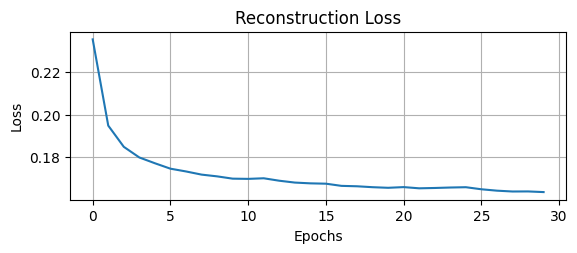

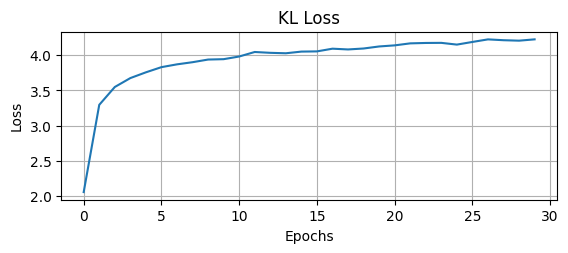

In [13]:
plot_losses(loss_train, loss_rec, loss_kl)

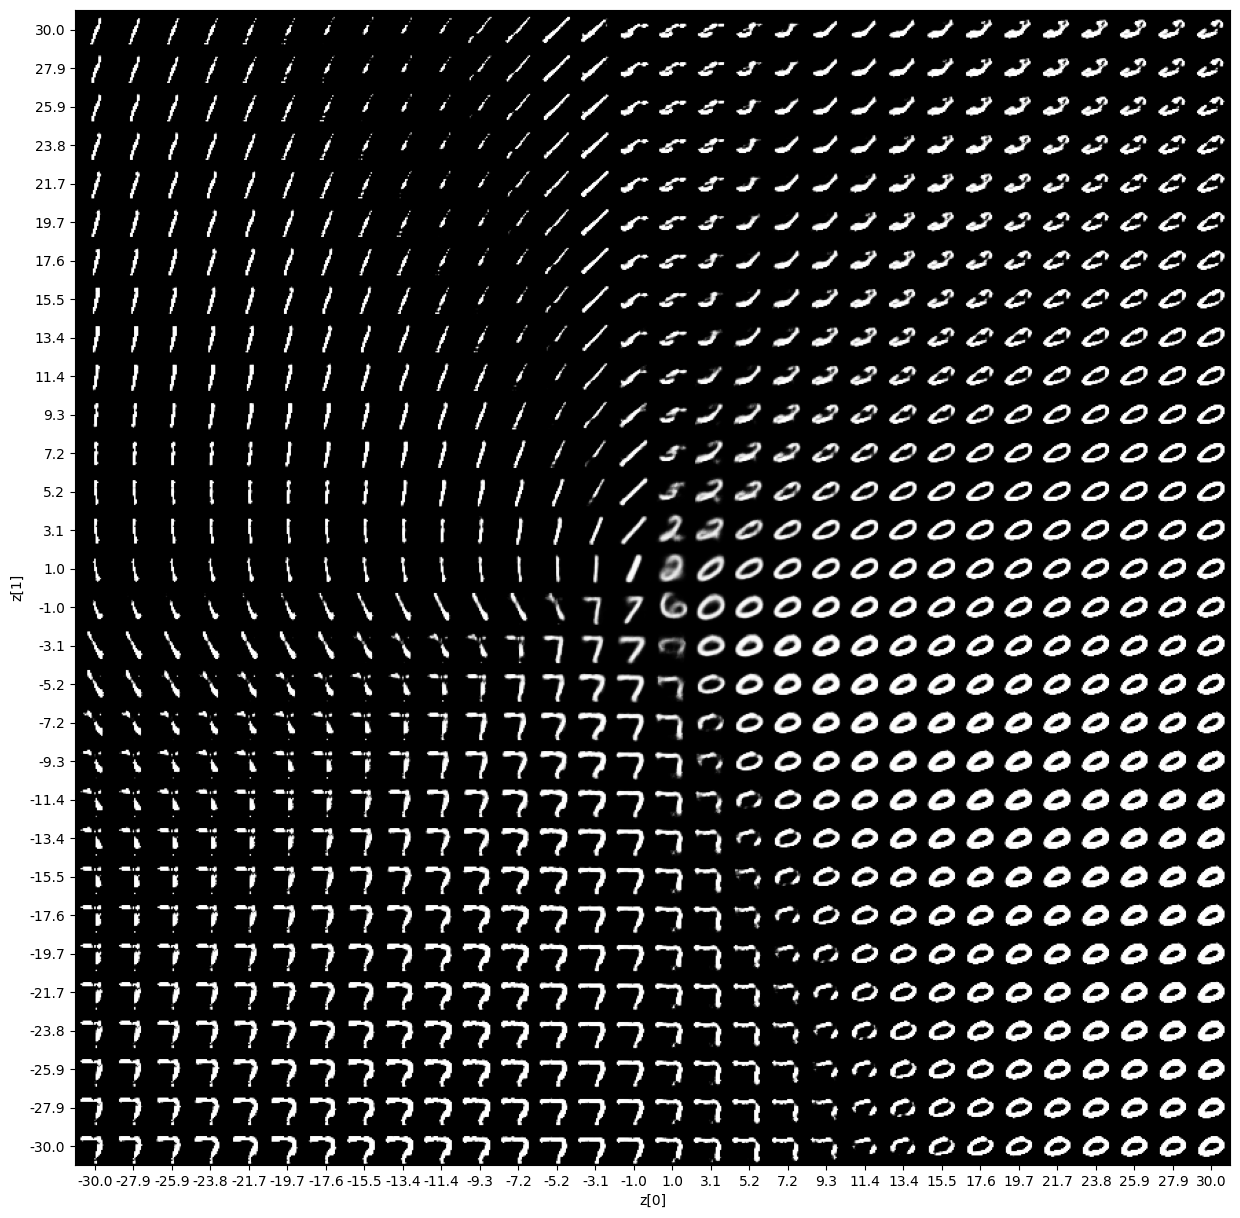

In [14]:
def plot_latent(decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    # here we systematically generate 2D samples of z_hat...
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # ...we cast and reshape the samples
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            # ...and then we pass them to the decoder, 
            # without keeping track of the gradient
            with torch.no_grad():
              x_decoded = vae.decode(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size).to('cpu')
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    # Finally we plot the generated data
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(2.0, 30) 

In [15]:
x_train, y_train = next(iter(DataLoader(MNIST, batch_size=len(MNIST))))

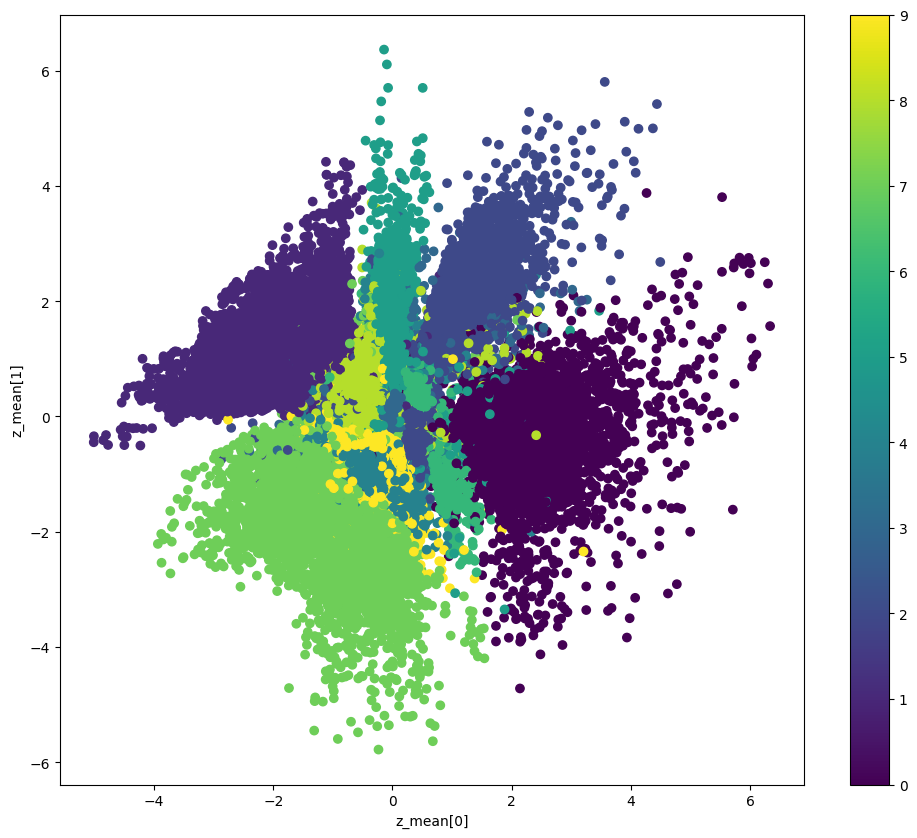

In [16]:
def plot_label_clusters(data, labels):
    with torch.no_grad():
      # let's compute the encodings 
      encoding = vae.encode(data.to(device))
      # and then the mean used in the reparameterization trick
      z_mean = vae.linear_mean(encoding).to('cpu')
    
    # Let's plot the latent space
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z_mean[0]")
    plt.ylabel("z_mean[1]")
    plt.show()

plot_label_clusters(x_train, y_train)